In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, pacf
from scipy.stats import ttest_ind
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import yfinance as yf
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# Annual Canadian Lynx Trappings

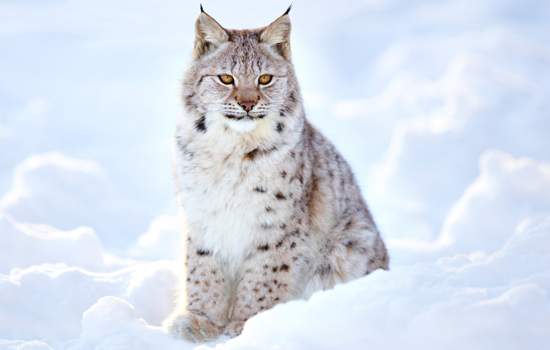

In [25]:

Image.open("nkar.jpg").resize((550,350))

def hide_code_in_slideshow():   
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

In [26]:

#from google.colab import drive
#drive.mount('/content/drive')

In [27]:
#lynx = pd.read_csv("/content/drive/MyDrive/Time Series/Annual_Canadian_Lynx_trappings_1821___1934_405_72.csv")
lynx = pd.read_csv("Annual_Canadian_Lynx_trappings_1821___1934_405_72.csv")
#lynx.index = pd.to_datetime(lynx.index)

In [28]:
lynx.head()

,Unnamed: 0,X,time,value
0,1,1,1821,269
1,2,2,1822,321
2,3,3,1823,585
3,4,4,1824,871
4,5,5,1825,1475


In [29]:
lynx = lynx.drop(["Unnamed: 0", "X"], axis=1)


# Overview of the data

In [30]:
lynx.head()

,time,value
0,1821,269
1,1822,321
2,1823,585
3,1824,871
4,1825,1475


In [31]:
minY = lynx.time.min()
maxY = lynx.time.max()
print("Time interval")
print(f"{minY} - {maxY}")

Time interval
1821 - 1934


<AxesSubplot:xlabel='time', ylabel='value'>

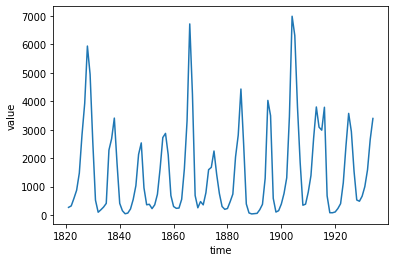

In [32]:
sns.lineplot(x="time", y="value", data=lynx)


# Model training

In [33]:
train_portion=0.95
lynx_train, lynx_test = lynx.iloc[:int(train_portion*len(lynx))+1, :], lynx.iloc[int(train_portion*len(lynx)):, :]

In [34]:
lynx_train.shape

(109, 2)

In [35]:
lynx_test.shape

(6, 2)

<AxesSubplot:xlabel='time', ylabel='value'>

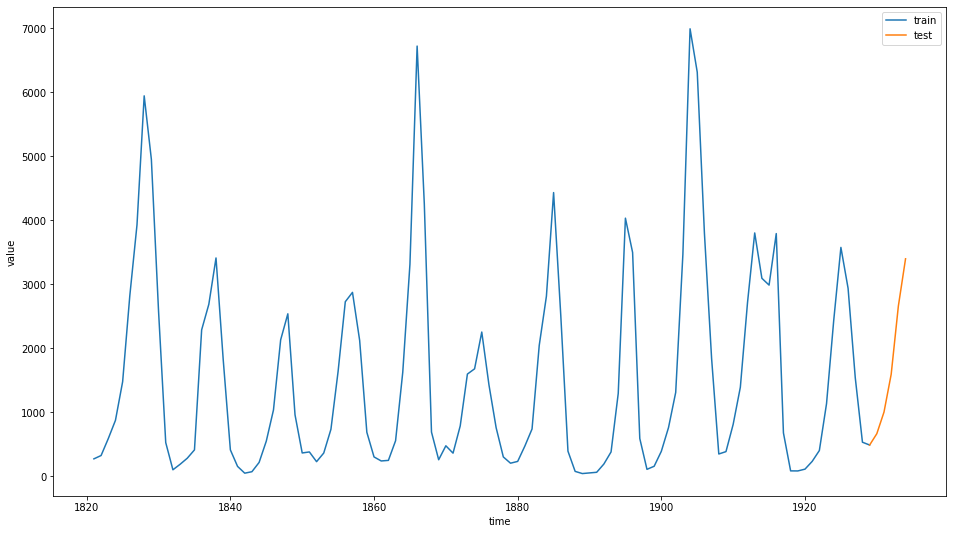

In [36]:
plt.figure(figsize=(16, 9))
sns.lineplot(x="time", y="value", data=lynx_train, label="train")
sns.lineplot(x="time", y="value", data=lynx_test, label="test")

# Stationarity

Weak Stationary times series has constant mean and variance

1. partition the data into random
2. analyse the summary statistics for different periods

means and variances are very close to each other -> stationary
means and variances differ significantly -> non-stationary

In [37]:
X = lynx_train.value
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print(f'mean1={mean1}, mean2={mean2}')
print(f'variance1={var1}, variance2={var2}')

mean1=1457.0740740740741, mean2=1588.1272727272728
variance1=2426584.0321453526, variance2=2765169.520538721


In [38]:
from tabulate import tabulate
mydata = [[mean1,var1], [mean2, var2]]
header = ["Mean", "Variance"]
print(tabulate(mydata, headers=header, tablefmt="fancy_grid"))



╒═════════╤═════════════╕
│    Mean │    Variance │
╞═════════╪═════════════╡
│ 1457.07 │ 2.42658e+06 │
├─────────┼─────────────┤
│ 1588.13 │ 2.76517e+06 │
╘═════════╧═════════════╛


## Augmented Dickey-Fuller Test

H0: The time series is not stationary. \
H1: The time series is stationary.

If the p-value is less than or equal to 0.05 or the absolute value of the test statistics is greater than the critical value, you reject H0 and conclude that the time series is stationary.

In [39]:
result = adfuller(lynx_train.value)
adf_test_stat = result[0]
critical_value_5 = result[4]["5%"]
p_value = result[1]

print(f"ADF Test Statistic: {adf_test_stat}")
print(f"5% critical value {critical_value_5}")
print(f"p-value {p_value}")

if p_value <= 0.05:
    print("Null hypotesis is rejected, the data is stationary")


ADF Test Statistic: -2.9569101946727794
5% critical value -2.8906107514600103
p-value 0.0391191219610405
Null hypotesis is rejected, the data is stationary


## Autocorrelation and Partial Autocorrelation functions

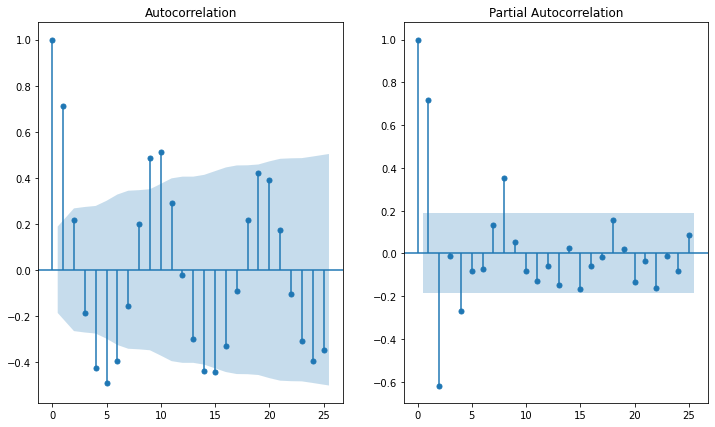

In [40]:

fix, ax = plt.subplots(1, 2, figsize=(12, 7))

lags = 25
sm.graphics.tsa.plot_acf(lynx_train.value.squeeze(), ax =ax[0], lags=lags);
sm.graphics.tsa.plot_pacf(lynx_train.value, ax=ax[1], lags=lags);

## Model Parameter Estimation Arima

In [41]:
model = pm.auto_arima(lynx_train["value"], stepwise=False, seasonal=False, stationary=True, trace=True, n_fits=100)

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1921.428, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1836.903, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1810.776, Time=0.35 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1810.778, Time=0.32 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=1809.714, Time=0.36 sec
 ARIMA(0,0,5)(0,0,0)[0] intercept   : AIC=1807.208, Time=0.52 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1845.644, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1811.772, Time=0.41 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1811.524, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1813.732, Time=0.42 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=1808.537, Time=0.58 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1799.682, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1801.729, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1800.672, Time=0.48 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1795.925, Time=1.05 sec
 ARIMA(3,0

In [42]:
best_model = ARIMA(lynx_train.value, order=(2, 0, 3))
result = best_model.fit()

In [43]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  109
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -887.087
Date:                Tue, 05 Apr 2022   AIC                           1788.173
Time:                        19:28:38   BIC                           1807.013
Sample:                             0   HQIC                          1795.813
                                - 109                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1523.2086    237.956      6.401      0.000    1056.823    1989.594
ar.L1          1.5854      0.010    157.517      0.000       1.566       1.605
ar.L2         -0.9980      0.006   -160.870      0.000      -1.010      -0.986
ma.L1         -0.8382      0.120     -7.001      0.000      -1.073      -0.604
ma.L2         -0.1026      0.141     -0.728      0.466      -0.379       0.174
ma.L3          0.6893      0.116      5.927      0.000       0.461       0.917
sigma2      7.381e+05      0.026    2.8e+07      0.000    7.38e+05    7.38e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.40   Jarque-Bera (JB):                72.54
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                             1.13
Prob(H) (two-sided):                  0.14   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.17e+23. Standard errors may be unstable.
"""

Diagnostics

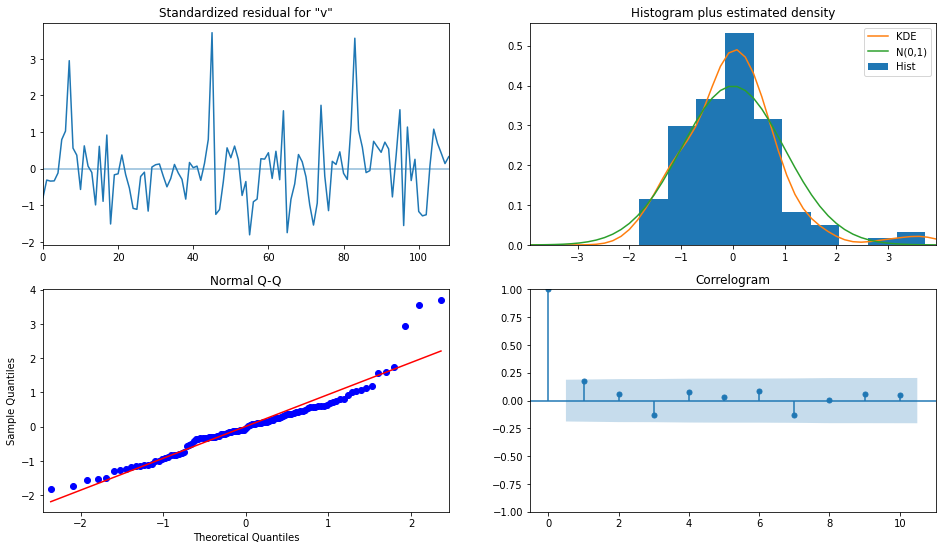

In [44]:

result.plot_diagnostics(figsize=(16, 9));

* The top-left plot shows the residuals over time and it appears to be a white noise with no seasonal component.

* The top-right plot shows that kde line (in red) closely follows the N(0,1) line, which is the standard notation of normal distribution with zero mean and standard deviation of 1, suggesting the residuals are normally distributed.

* The bottom-left normal QQ-plot shows ordered distribution of residuals (in blue) closely follow the linear trend of the samples taken from a standard normal distribution, suggesting residuals are normally distributed.

* The bottom-right is a correlogram plot indicating residuals have a low correlation with lagged versions.

Hence residuals are white noise

## Forecasting

In [45]:
forecast_object = result.get_forecast(steps=len(lynx_test))
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index

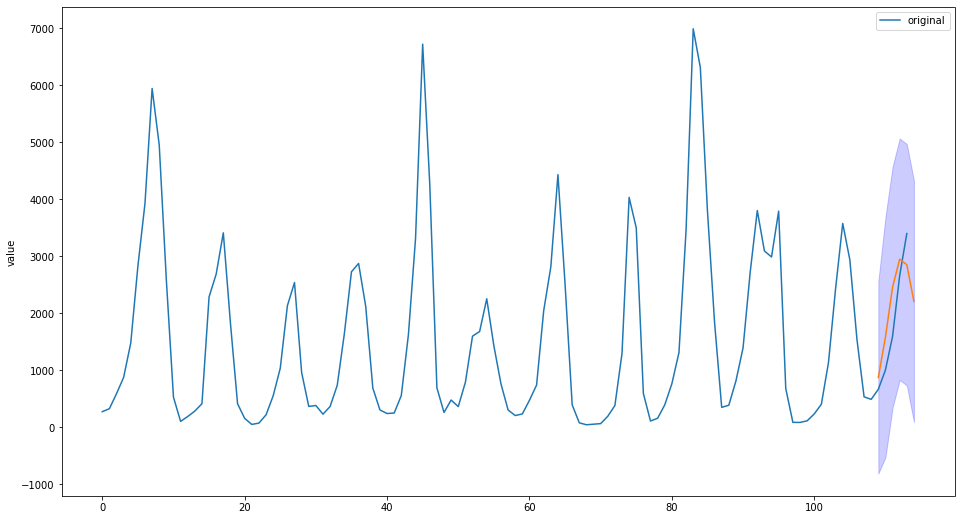

In [46]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=lynx.index, y=lynx.value,label="original")
sns.lineplot(mean.index, mean)
plt.fill_between(mean.index, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2, color= 'blue')